In [1]:
from typing import Annotated, Dict, List, Any
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

In [2]:
class IntentState(TypedDict):
    messages: Annotated[List, add_messages]

In [3]:
def route(state: IntentState) -> str:
    last_message = state['messages'][-1].content.lower()
    if any(word in last_message for word in ['hey', 'hello', 'good morning', 'good afternoon', 'good evening', 'good night']):
        return "greet"
    if any(word in last_message for word in ['bye', 'seeyou', 'good bye']):
        return 'bye'
    if any(symbol in last_message for symbol in ['+', '-', '*', '/']):
        return 'math'
    else:
        return 'fallback'

In [4]:
def greet_node(state: IntentState) -> Dict[str, Any]:
    response = "Hi, so good to hear from you!"
    return {'messages': [AIMessage(content=response)]}

In [5]:
def bye_node(state: IntentState) -> Dict[str, Any]:
    response = "Ok, Bye!"
    return {'messages': [AIMessage(content=response)]}

In [6]:
def fallback(state: IntentState) -> Dict[str, Any]:
    response = "I will come back to you in a while"
    return {'messages': [AIMessage(content=response)]}

In [7]:
def math_node(state: IntentState) -> Dict[str, Any]:
    expression = state['messages'][-1].content
    try:
        result = eval(expression)
        reply = f"The answer is {str(result)}"
    except Exception as e:
        reply = "Sorry Could not calculate that"
    return {'messages': [AIMessage(content=reply)]}

In [8]:
graph = StateGraph(IntentState)
graph.add_node('greet_node', greet_node)
graph.add_node('bye_node', bye_node)
graph.add_node('fallback', fallback)
graph.add_node('math_node', math_node)

graph.add_conditional_edges(
    START,
    route,
    {
        'greet': 'greet_node',
        'bye': 'bye_node',
        'math': 'math_node',
        'fallback': 'fallback'
    }
)
graph.add_edge('greet_node', END)
graph.add_edge('bye_node', END)
graph.add_edge('fallback', END)
graph.add_edge('math_node', END)

app = graph.compile()

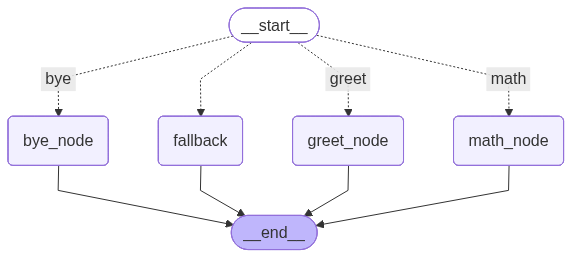

In [9]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [14]:
def test(user_input):
    state: IntentState = {
        "messages": [HumanMessage(content=user_input)],
    }
    state = app.invoke(state)
    print("\n--- Response 1 ---")
    for m in state["messages"]:
        print(m.__class__.__name__, ":", m.content)

In [15]:
test("2+2")


--- Response 1 ---
HumanMessage : 2+2
AIMessage : The answer is 4


In [17]:
test("good morning")


--- Response 1 ---
HumanMessage : good morning
AIMessage : Hi, so good to hear from you!


In [18]:
test("bye")


--- Response 1 ---
HumanMessage : bye
AIMessage : Ok, Bye!


In [19]:
test("Who is the PM of India")


--- Response 1 ---
HumanMessage : Who is the PM of India
AIMessage : I will come back to you in a while
